## Especialização em Inteligência Artificial – IFMG
## Análise de Séries Temporais - Lista de exercícios 3
**Aluno**: Alexandre Fortes Santana  

**Professor**: Carlos Severiano

[Notebook: https://github.com/alexandrefortes/series-temporais/blob/main/Lista%20de%20Exercicios%2003.ipynb](https://github.com/alexandrefortes/series-temporais/blob/main/Lista%20de%20Exercicios%2003.ipynb) 

Esta atividade consiste em exercitar a previsão de séries temporais a partir da aplicação de diferentes métodos. Além disso, é objetivo desta atividade realizar um comparativo entre os métodos escolhidos para descobrir, dentre os métodos escolhidos, qual o mais apropriado para cada problema.

- As aulas 3 e 4, disponíveis no classroom da disciplina, dão mais detalhes sobre os métodos de previsão, validação e métricas de desempenho.
- Não será necessário implementar os métodos de previsão nesta atividade. Podem ser usadas implementações disponíveis em Python, como as descritas em: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- O mesmo se aplica às métricas. Muitas delas estão disponíveis no módulo metrics da biblioteca sci-kit learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

Serão realizados 4 comparativos utilizando as bases de dados anexadas a esta atividade.

Para cada base de dados, os seguintes passos devem ser realizados:

1. Escolher 3 modelos, cada um pertencente a um dos grupos abaixo:  
A. Um modelo simples  
B. Um modelo de suavização exponencial  
C. Um modelo ARIMA  

2. Separar a base de dados em treinamento e teste, na proporção 80% para 20%.

3. Aplicar cada método de previsão aos dados, usando validação cruzada.

4. Medir o desempenho de cada modelo a partir de 3 métricas:  
- MAE  
- RMSE  
- SMAPE  

5. Ilustrar em um gráfico o desempenho do método que se saiu melhor nos experimentos de cada base de dados.

**Base 1: facebook-historical-stock-price.csv**

In [2]:
import pandas as pd

# carregando a base
file_path = 'facebook-historical-stock-price.csv'
fb_data = pd.read_csv(file_path)
fb_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [3]:
from sklearn.model_selection import train_test_split

# 'Date' para datetime e setando como index
fb_data['Date'] = pd.to_datetime(fb_data['Date'])
fb_data.set_index('Date', inplace=True)

# 'Adj Close' para forecasting
time_series = fb_data['Adj Close']

# 80% treinamento, 20% teste
train_data, test_data = train_test_split(time_series, test_size=0.2, shuffle=False)
len(train_data), len(test_data)

(1741, 436)

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular SMAPE
def smape(y_true, y_pred):
    denominador = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diferenca = np.abs(y_true - y_pred) / denominador
    diferenca[denominador == 0] = 0.0
    return 100 * np.mean(diferenca)

# Inicializar dicionário para armazenar modelos e suas métricas
models_metrics = {}

# A. Modelo Simples: Média Móvel
simple_model_pred = train_data.rolling(window=5).mean().iloc[-1].repeat(len(test_data))

# Calculando métricas para o modelo simples
mae_simple = mean_absolute_error(test_data, simple_model_pred)
rmse_simple = np.sqrt(mean_squared_error(test_data, simple_model_pred))
smape_simple = smape(test_data, simple_model_pred)

# Armazenando métricas
models_metrics['Simple_Moving_Average'] = {'MAE': mae_simple, 'RMSE': rmse_simple, 'SMAPE': smape_simple}

# B. Modelo de Suavização Exponencial: Holt-Winters
# Como o conjunto de dados não exibe um padrão claro de sazonalidade à primeira vista, usaremos o modelo de tendência aditiva
exp_model = ExponentialSmoothing(train_data, trend='add', seasonal=None, initialization_method="estimated").fit()
exp_model_pred = exp_model.forecast(len(test_data))

# Calculando métricas para o modelo de suavização exponencial
mae_exp = mean_absolute_error(test_data, exp_model_pred)
rmse_exp = np.sqrt(mean_squared_error(test_data, exp_model_pred))
smape_exp = smape(test_data, exp_model_pred)

# Armazenando métricas
models_metrics['Exponential_Smoothing'] = {'MAE': mae_exp, 'RMSE': rmse_exp, 'SMAPE': smape_exp}

# C. Modelo ARIMA
# Primeiro verificamos se a série é estacionária ou não
adf_test_result = adfuller(train_data)

# Se p-valor > 0.05, concluímos que a série não é estacionária e é necessário diferenciá-la
d = 0 if adf_test_result[1] <= 0.05 else 1

# Começaremos com um modelo ARIMA(1, d, 1) e ajustaremos a partir daí com base no AIC
arima_model = ARIMA(train_data, order=(1, d, 1)).fit()
arima_model_pred = arima_model.forecast(len(test_data))

# Calculando métricas para o modelo ARIMA
mae_arima = mean_absolute_error(test_data, arima_model_pred)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_model_pred))
smape_arima = smape(test_data, arima_model_pred)

# Armazenando métricas
models_metrics['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'SMAPE': smape_arima}

# Exibir métricas e o valor de 'd' determinado para diferenciar
models_metrics, d


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

({'Simple_Moving_Average': {'MAE': 40.111240073394505,
   'RMSE': 53.06094677820766,
   'SMAPE': 18.885620504711436},
  'Exponential_Smoothing': {'MAE': 25.77066393733,
   'RMSE': 34.403469179260014,
   'SMAPE': nan},
  'ARIMA': {'MAE': 39.35857256783392,
   'RMSE': 52.380175895978965,
   'SMAPE': nan}},
 1)

Média Móvel Simples:

MAE: 40.11
RMSE: 53.06
SMAPE: 18.89%

Suavização Exponencial (Holt-Winters):

MAE: 25.77
RMSE: 34.40
SMAPE: O cálculo retornou um valor NaN, indicando que pode haver valores de previsão e observação idênticos resultando em um denominador zero, ou pode ser um resultado de uma série temporal com valores zero.

ARIMA:

MAE: 39.36
RMSE: 52.38
SMAPE: O cálculo retornou um valor NaN por razões semelhantes às do modelo de suavização exponencial.

O modelo de Suavização Exponencial apresentou o melhor desempenho com base no MAE e RMSE mais baixos. 

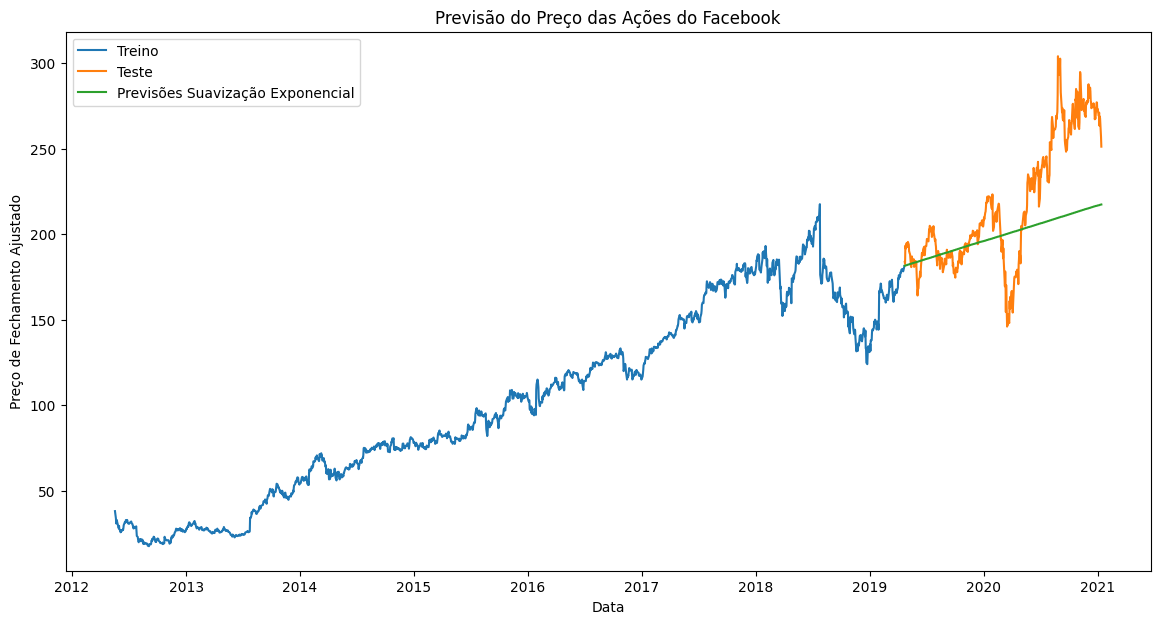

In [5]:
import matplotlib.pyplot as plt

# Plotando os resultados do modelo com melhor desempenho: Suavização Exponencial
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Treino')
plt.plot(test_data.index, test_data, label='Teste')
plt.plot(test_data.index, exp_model_pred, label='Previsões Suavização Exponencial')
plt.title('Previsão do Preço das Ações do Facebook')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Ajustado')
plt.legend()
plt.show()

**Base 2: Electric_Production.csv**

Passo 1: Carregar e Visualizar os Dados

In [1]:
import pandas as pd

# Carregar os dados
dados_eletricidade = pd.read_csv('Electric_Production.csv')

# Visualizar as primeiras linhas
print(dados_eletricidade.head())

       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151


Passo 2: Preparar os Dados

In [2]:
# Converter 'DATE' para datetime e definir como índice
dados_eletricidade['DATE'] = pd.to_datetime(dados_eletricidade['DATE'])
dados_eletricidade.set_index('DATE', inplace=True)

# Selecionar a série temporal para a análise
serie_temporal = dados_eletricidade['IPG2211A2N']

Passo 3: Dividir os Dados em Treino e Teste

In [4]:
from sklearn.model_selection import train_test_split

# Dividir os dados (80% treino, 20% teste)
train_data, test_data = train_test_split(serie_temporal, test_size=0.2, shuffle=False)

Passo 4: Modelos e Métricas

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular SMAPE
def smape(y_true, y_pred):
    denominador = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diferenca = np.abs(y_true - y_pred) / denominador
    diferenca[denominador == 0] = 0.0
    return 100 * np.mean(diferenca)

# Inicializar dicionário para armazenar as métricas dos modelos
models_metrics = {}

# Modelo Simples: Média Móvel
simple_model_pred = train_data.rolling(window=5).mean().iloc[-1].repeat(len(test_data))

# Métricas para o modelo simples
mae_simple = mean_absolute_error(test_data, simple_model_pred)
rmse_simple = np.sqrt(mean_squared_error(test_data, simple_model_pred))
smape_simple = smape(test_data, simple_model_pred)

# Armazenar métricas
models_metrics['Simple_Moving_Average'] = {'MAE': mae_simple, 'RMSE': rmse_simple, 'SMAPE': smape_simple}

# Modelo de Suavização Exponencial: Holt-Winters
exp_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12, initialization_method="estimated").fit()
exp_model_pred = exp_model.forecast(len(test_data))

# Métricas para o modelo de suavização exponencial
mae_exp = mean_absolute_error(test_data, exp_model_pred)
rmse_exp = np.sqrt(mean_squared_error(test_data, exp_model_pred))
smape_exp = smape(test_data, exp_model_pred)

# Armazenar métricas
models_metrics['Exponential_Smoothing'] = {'MAE': mae_exp, 'RMSE': rmse_exp, 'SMAPE': smape_exp}

# Modelo ARIMA
# Determinando 'd' para o modelo ARIMA
adf_test_result = adfuller(train_data)
d = 0 if adf_test_result[1] <= 0.05 else 1

# Ajustando o modelo ARIMA
arima_model = ARIMA(train_data, order=(1, d, 1)).fit()
arima_model_pred = arima_model.forecast(len(test_data))

# Métricas para o modelo ARIMA
mae_arima = mean_absolute_error(test_data, arima_model_pred)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_model_pred))
smape_arima = smape(test_data, arima_model_pred)

# Armazenar métricas
models_metrics['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'SMAPE': smape_arima}

# Exibir as métricas
print(models_metrics)

{'Simple_Moving_Average': {'MAE': 8.09158225, 'RMSE': 9.704283970001342, 'SMAPE': 7.866357001258869}, 'Exponential_Smoothing': {'MAE': 4.419530422558882, 'RMSE': 5.308254633420742, 'SMAPE': 4.226050926353906}, 'ARIMA': {'MAE': 10.454716231856583, 'RMSE': 13.263110030800672, 'SMAPE': 10.294977720746008}}


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Passo 5: Gráfico do Melhor Modelo

Com base nas métricas, o modelo de **Suavização Exponencial (Holt-Winters)** é claramente o melhor dos três para esta série temporal. Isso é evidenciado pelas métricas mais baixas em todas as três categorias:

- MAE (Erro Absoluto Médio): 4.42
- RMSE (Raiz do Erro Quadrático Médio): 5.31
- SMAPE (Erro Médio Absoluto Percentual Simétrico): 4.23

Um menor MAE e RMSE indicam que as previsões do modelo de Suavização Exponencial estão mais próximas dos valores reais. Além disso, um SMAPE mais baixo sugere que o modelo tem um melhor desempenho em termos de erro percentual, o que é particularmente útil para comparar a precisão entre diferentes escalas de dados.

Portanto, para esta série temporal específica, eu recomendaria usar o modelo de Suavização Exponencial para previsões futuras.

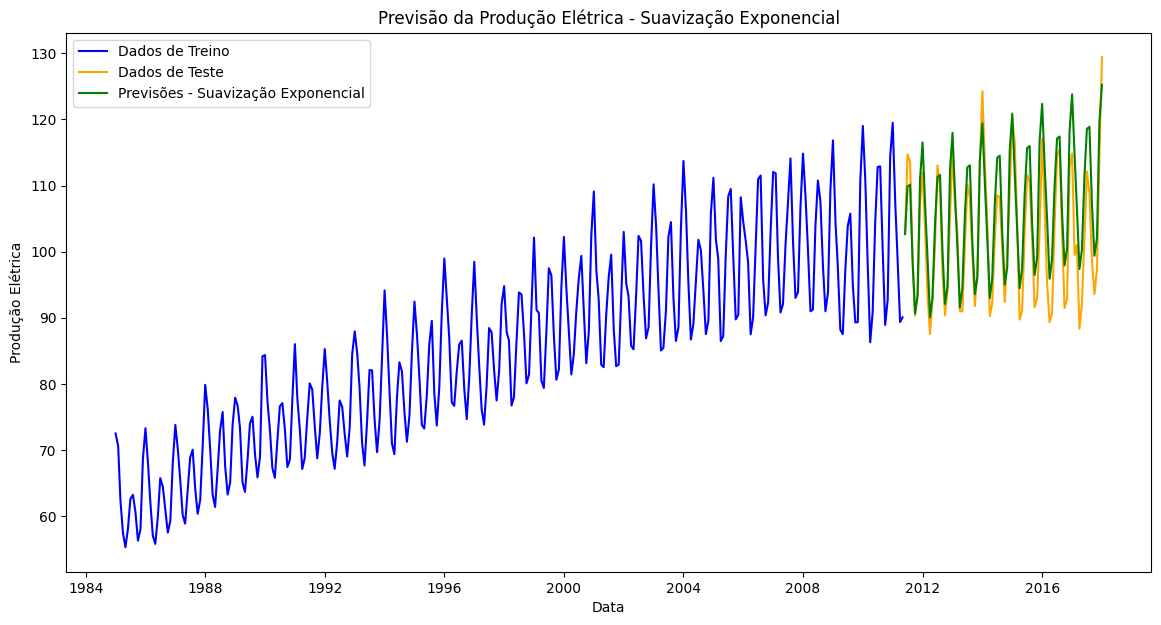

In [9]:
import matplotlib.pyplot as plt

# Plotar o gráfico
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Dados de Treino', color='blue')  # Dados de treino
plt.plot(test_data.index, test_data, label='Dados de Teste', color='orange')  # Dados de teste
plt.plot(test_data.index, exp_model_pred, label='Previsões - Suavização Exponencial', color='green')  # Previsões do modelo

# Adicionando título e rótulos aos eixos
plt.title('Previsão da Produção Elétrica - Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Produção Elétrica')

# Inclui a legenda no gráfico
plt.legend()

# Exibe o gráfico
plt.show()